### Square-Wave lock-in Analysis. 

This program works to download the lock-in ODMR data from a .dat file and anlayse the data to extract the ODMR contrast by fitting a square wave to each applied microwave frequency used during the experiment and for each repeated line scan in the dataset. 

In addition, as this is the first time properly implementing square wave-analysis, I will also add in a seciton in which the R-squared value for each sqaure-wave fitting for the first line of the lock-in ODMR dataset is recorded and plotted. This is because I am using an extremely rough fitting algorithm currently. So It would be nice to see how accurate the fitting used in this program really is. 

We start by importing the dependencies for the script

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plot 
import scipy.optimize as opt
import os
import scipy.signal as sig

Load in the dataset and the parameters used during the experiment. 

In [2]:
def load_data(file_path): 
    '''load the ODMR data file in to a np array'''
    
    data_array = np.loadtxt(file_path)
    return(data_array)

In [3]:
def load_params(file_path):
    '''load in the params data.''' 
    params_data = pd.read_table(file_path, names = ['Parameter name', 'Parameter value']) 
    return(params_data)

Create the frequency scan array. 

This is not actually the true frequency scan array used. I will explain. 

If we have the following parameters for the scan. 

Microwave frequnecy dwell time = 10ms, Laser modulation frequency = 1kHz (dwell time = 1ms) and Sample rate = 10kHz (dwell time = 0.1ms).

We have 100 data points recorded per microwave frequnecy. So, the frequnecy array reflects the number of data-points recorded, rather than the actual frequnecy applied. This is only used for the heat-map plotting, so it is not too much of a fudge. Also, we can recover the actual applied frequnecy if we multiply the frequency array by a factor of 10^n which gets the microwave applied frequnecy in the same unit base as the set (eg: convert GHz to MHz) and using np.floor to extract the actual applied frequnecy used. 

In [4]:
def create_freq_scan(start, stop, step_size):
    '''takes the scan parameters from the params data file.''' 
    step_size_GHz = step_size/1000
    number_of_steps = int((stop-start)/step_size_GHz)+1
    freq = np.linspace(start, stop, number_of_steps)
    return(freq)

In [5]:
 def set_plot_params():
    '''formats the plot parameters '''
    plot.rcParams.update({'font.size' : 20})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

Plot the data as a heat map. 

Because the data supplied here can be lock-in data, the heat-map is likely to have a checker-board or striated look to it, reflecting the high and low power modes of the modulation. 

In [6]:
def plot_heat_map(freq, odmr_data, dwell_time):
    '''plot the full ODMR data as a heatmap.''' 
    number_of_scans = len(odmr_data)
    Y = np.linspace(1, number_of_scans, number_of_scans) 
    
    fig1, ax1 = plot.subplots()
    
    hm = ax1.pcolormesh(freq, Y, odmr_data[:,0:len(freq)], cmap = 'viridis')
    fig1.colorbar(hm, label = '\ncounts per ' + str(dwell_time) + r' $\mu$s')
    ax1.set_xlim(np.min(freq),np.max(freq))
    ax1.set_xticks(np.arange(np.min(freq), np.max(freq), 0.05))
    ax1.set_xlabel('Microwave Frequency (GHz)')
    ax1.set_ylabel('Number of scans')
    
    return(fig1, ax1)

The demodulate_signal method is legacy code. It fits the square wave to a full line scan. This results in what looks like drift in the ODMR data. This is because there is a phase error that creaps into the analysis. I am keeping this code because I may want to show this effect later on and its way easier to keep the code than delete it and try to write it again in the future. 

The demodulate_signal_2 is the useable code that acts to fit a sqaure wave signal to the lock-in dataset for each of the applied frequencies used in the experiment. 

In [18]:
def demodulate_square_sig(odmr_data, mod_freq, pixel_dwell_time, microwave_dwell_time, duty):
    '''For lock-in detection to work, I am going to need to demodulate the 
    signal recorded by multiplying it by a square wave with a frequency of mod_freq.'''
        
    # Create a "time" array that has the values 0-(length of a single lock-in line scan)
    time = np.arange(0, pixel_dwell_time*(len(odmr_data[1,:])), pixel_dwell_time)
    
    # Determine the sample rate of data-points per microwave frequnecy.
    points_per_freq = microwave_dwell_time/pixel_dwell_time
    
    # Find the shape of the ODMR data-set. 
    x, y = odmr_data.shape
    
    # Create variables for analysed data to be stored in. 
    demod_signal = pd.DataFrame()
    mod_signal = []
    
    # for loop loops for the number of line scans. 
    for i in range(len(odmr_data)):
        # loops for the number of frequnecies in the data-set. 
       
        mod_signal  = [] 
        for j in range(int((len(odmr_data[i,:])/points_per_freq))):
            # find the indicies of all points corresponding to the jth Frequency applied. 
            indicies = np.arange(j*points_per_freq, (j+1)*points_per_freq, 1, dtype = int)
            
            # extract the relavant fluorescence intensity for this measurement.
            y_data = odmr_data[i, indicies]
            square = zeros_and_ones(y_data)
            mod_signal.append(square)
            
            #phase = find_phase_constant(y_data, pixel_dwell_time, mod_freq)
            
            # Inital fitting values and limits            
           # p0 = [0.5*(np.max(y_data) - np.min(y_data)), mod_freq, np.mean(y_data), duty, phase]
           # lower_bound = [p0[0]*0.5, mod_freq*0.99, 0, duty-0.1, 0]
           # upper_bound = [p0[0]*1.5, mod_freq*1.01, np.max(y_data), duty+0.1, 2*np.pi]
            
            # Perform a sqaure wave fitting for the jth frequnecy data. 
          #  mod_signal_params, confidence = opt.curve_fit(square_wave, time[indicies], y_data, 
          #                                                p0, bounds = (lower_bound, upper_bound))
            
            # Store the fitted square wave in a list
            # mod_signal.append(square_wave(time[indicies], 1, mod_signal_params[1],
             #           0, mod_signal_params[3], mod_signal_params[4]))
        
            
        
        
        # convert list to array
        mod_signal = np.array(mod_signal)
        mod_signal = mod_signal.reshape(y-1)
        # Demodulate the ith line scan. 
        demod_signal[str(i)] = pd.Series(odmr_data[i,0:y-1]*mod_signal)
        # Reset the mod_signal variable. 
        
    
     # Code to plot the first 100 points of the lock-in data and the modulated signal. 
    # This is to visually check that the fitting is working okay. 
    fig2, ax2 = plot.subplots()
   
    ax2.scatter(time[0:100], odmr_data[i,0:100])
    ax2.plot(time[0:100], mod_signal[0:100]*25)
    return(demod_signal)

In [8]:
def create_square_wave(x, A, B, C, D, phi):
    '''generate a sqaure wave 
    A = amplitude, B = frequency, C = Y offset.
    D = duty cycle, phi = phase constant. '''
    
    y = A*sig.square(2*np.pi*B*x + phi, duty = D) + C
    return(y)

In [9]:
def find_phase_constant(y, pixel_dwell_time, mod_freq):
    '''This is our method of approximating thephase constant of a square wave. 
    The way the program works is to take 1 full AOM modulation cycle and see where in the 
    cycle that the AOM flips from being in an OFF state to an ON state. By working out at what point
    this occurs in terms of the number of sample points per AOM modulatin cycle, we can approximate
    the phase constant of the wave form. 
    
    eg: If we have 10 sample points per AOM cycle, and at the 3rd data point, we see from the 
    data that the AOM has turned on (high ) then we can approximate the phase constant for this 
    dataset to be: 
    
    phi = pi * (3/10) OR pi * (Point at which AOM switches on / Total number of sample points.)'''
    
    # Generate the sample frequency rate (Hz)
    pixel_dwell_time = pixel_dwell_time*10**-6 # pixel dwell time in seconds. 
    sampling_freq = 1/pixel_dwell_time
    
    # sample points per laser modulation cycle
    points_per_laser_cycle =  int(sampling_freq/mod_freq)
    
    # find the mean fluorescence intensity
    mean_counts = np.mean(y)
    
    # empty variable.
    ratio = []
    
    
    for i in range(points_per_laser_cycle):
        # sort 1 full wavelength of data into whether the 
        # AOM is in ON or OFF mode. 
        if y[i] > mean_counts:
            ratio.append(1)
        else:
            ratio.append(0)
    ratio = np.array(ratio)
    
    
    # Find the points where the laser is on.
    find_indicies = np.where(ratio==1)[0]
    
    # empty variable
    index = []
    
    for i in range(len(find_indicies)-1):
        # find the point at which the laser shifts from being off
        # to on.
        if find_indicies[i]+1 != find_indicies[i+1]:
            index.append(i+1)
    
    # We might catch the AOM at the perfect start to a 
    # modulation cycle, in which case phase constant = 0. 
    if index == []:
        index.append(find_indicies[0])
    
    # convert the ration of points in the on and off in the first half of 
    # a AOM modulation cycle into a phase constant. 
    phase_constant_guess = ((index[0]+1)*(2*np.pi))/points_per_laser_cycle
    
    return(phase_constant_guess)

In [21]:
def zeros_and_ones(data_set):
    '''This program is a potential cheat way to generate the square wave for lock-in amplification'''
    
    mean_intensity = np.mean(data_set)
    cut_off = mean_intensity/2
    squares = []
    
    for i in range(len(data_set)):
        # sort 1 full wavelength of data into whether the 
        # AOM is in ON or OFF mode. 
        if data_set[i] > cut_off:
            squares.append(1)
        else:
            squares.append(0)
    sqaures = np.array(squares)
    
    return(squares)

In [11]:
def low_pass_filter(demod_signal, mod_freq, microwave_dwell_time, pixel_dwell_time):
    '''Average over a number of data points to recover the ODMR signal. '''
    
    # Find the number of data_points per microwave frequnecy. 
    average_points = int(microwave_dwell_time/pixel_dwell_time)
    # Generate a pandas array for the low pass filter (lpf) data. 
    lpf_odmr = pd.DataFrame()
    averaged_data = []
    
    # loop through the number line scans
    for i in range(demod_signal.shape[1]):
        # Test if the data is an np array or a pandas array and load into a variable 
        # called intensity.
        try:
            intensity = demod_signal[i]
        except: 
            intensity = demod_signal[str(i)]
        # loop through the number of frequencies in the dataset. 
        for j in range(int(len(intensity)/average_points)):
            # Find the mean of the fluorescence intensity for each frequnecy. 
            averaged_data.append(np.mean(intensity[average_points*j:average_points*j+(average_points-1)]))
            # Make sure the data is position (stops if modulation signal is pi out of phase. )
            averaged_data2 = np.sqrt(np.power(averaged_data,2))
        # Append data to the pandas array. 
        lpf_odmr[str(i)] = pd.Series(averaged_data2)
        # reset averaged data. 
        averaged_data = [] 
    return(lpf_odmr)

In [12]:
def plot_lpf_signal(start_freq, stop_freq, dwell_time, lpf_odmr): 
    '''Plot the demodulated signal as a scatter graph.'''
    
    # Take a mean of the low pass filtered data. 
    mean_lpf_odmr = lpf_odmr.mean(axis = 1)
    
    # Create a frequnecy array that reflects the actual frequnecy array used in experiment. 
    freq = np.linspace(start_freq, stop_freq, len(mean_lpf_odmr))
    
    #Create a new figure and plot the data. 
    fig2, ax2 = plot.subplots()
    ax2.scatter(freq, mean_lpf_odmr, marker = 'x', color = 'k',
               label = 'Lock-in ODMR data')
    ax2.set_xlabel('Microwave Frequency (GHz)')
    ax2.set_ylabel('Counts (per ' + str(round((dwell_time/2),3)) + r' $\mu$s)')
    
    ax2.legend(loc = 'lower left')
    
   # lock_in_data = pd.DataFrame([freq, mean_lpf_odmr], columns = ['Frequency (GHz)', 'Lock-in Signal (counts per '+ str(round((dwell_time/2),3)) + r' $\mu$s)'])
    
    return(fig2, ax2, freq)

In [13]:
def drift_check_plot(lpf_odmr, dwell_time):
    # create a plot of the average fluorescence intensity recorded per 
    # line-scan to check for drift in the sample. 
    
    mean_fluorescence_per_line = lpf_odmr.mean(axis = 0)
    scan_array = np.arange(0, len(mean_fluorescence_per_line), 1)
    fig3, ax3 = plot.subplots()
    ax3.scatter(scan_array, mean_fluorescence_per_line, marker = 'x', 
               color='k', label='mean fluorescence \nintensity per line scan')
    ax3.set_xlabel('Line Scan number')
    ax3.set_ylabel('Counts (per ' + str(round((dwell_time/2),3)) + r' $\mu$s)')
    ax3.legend(loc='lower left')
    return(fig3, ax3)

In [14]:
def save_data(date, file_ID, frequency, intensity, dwell_time, fig1, fig2, fig3):
    
    destination_folder = 'H:\\My Documents\\Strathclyde_Back_up\\Graphs_and_analysis\\ODMR\\' + date + '\\' +'Lock_in\\'
    output_data_file = destination_folder + file_ID + '_lock_in_averaged_results.dat'
    
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('Frequency (GHz)' + '\t' + 'Counts (per ' + str(round((dwell_time/2),3)) + r' $\mu$s)' + '\n')
    # Writing contrast dip description to the .dat file
    
    for i in range(len(frequency)):
        with open(output_data_file, "a") as wf:
            wf.write(str(frequency[i]) + " \t"  + str(intensity[i]) + " \n")
        
    # Saving a plot of the raw data to a folder. 
    fig1.savefig(destination_folder + file_ID + '_lock_in_' +'_Heat_Map' + '.png')
    fig1.savefig(destination_folder + file_ID + '_lock_in_' +'_Heat_Map' + '.pdf')

    fig2.savefig(destination_folder + file_ID + '_Lock-in_scatter' + '.png')
    fig2.savefig(destination_folder + file_ID + '_Lock-in_scatter' + '.pdf')

    fig3.savefig(destination_folder + file_ID + '_lock_in_drift' + '.png')
    fig3.savefig(destination_folder + file_ID + '_lock_in_drift' + '.pdf')

    

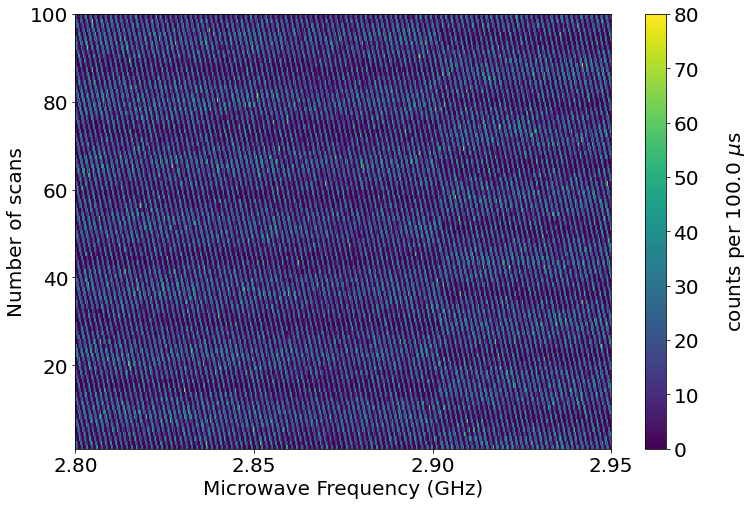

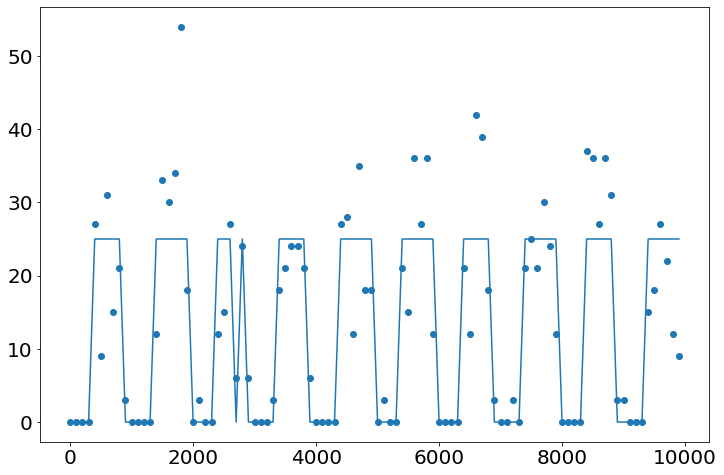

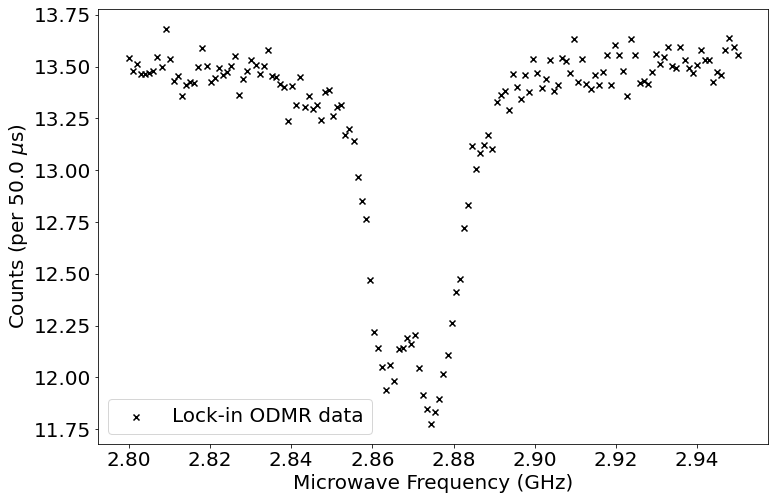

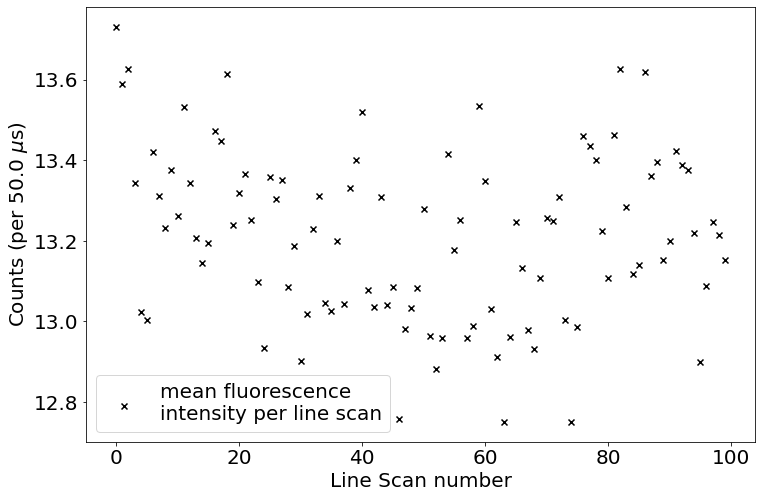

In [22]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
 # Saves this data into a text file and the 2 plots generated. 
#######

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\'
date = '20210303'
file_name = date + '_NVScan_03'

odmr_data = load_data(folder_path + date + '\\' + file_name + '.dat')
params_file = load_params(folder_path + date + '\\' + file_name + 'Params.dat')
params_values = params_file['Parameter value']

# Create the freqeuncy scan array. 
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])

# plot a colour map of the ODMR data and set plot format for the program. 
set_plot_params()

pixel_dwell_time = params_values[3] # Pixel Dwell time in microseconds
microwave_dwell_time = params_values[6] # Microwave Dwell time in microseconds
mod_freq = params_values[7] # AOM modulation frequnecy.
duty = 0.5 # Set the duty cycle for the modulation.

fig1, ax1 = plot_heat_map(freq, odmr_data, pixel_dwell_time)

if mod_freq == 0:
    demod_odmr = pd.DataFrame(np.transpose(odmr_data))
else:
    # demodulate the signal
    demod_odmr = demodulate_square_sig(odmr_data, mod_freq, pixel_dwell_time, microwave_dwell_time, duty)

# Perform Low-pass filtering (averaging)
lpf_odmr = low_pass_filter(demod_odmr, mod_freq, microwave_dwell_time, pixel_dwell_time)

fig2, ax2, freq = plot_lpf_signal(params_values[0], params_values[1], pixel_dwell_time, lpf_odmr)

fig3, ax3 = drift_check_plot(lpf_odmr, pixel_dwell_time)

#save_data(date, file_name, freq, lpf_odmr.mean(axis = 1), pixel_dwell_time, fig1, fig2, fig3)

In [ ]:
#demodulate_square_sig(odmr_data, mod_freq, pixel_dwell_time, microwave_dwell_time, duty)

[2]
1.8849555921538759
1.2566370614359172
14.82


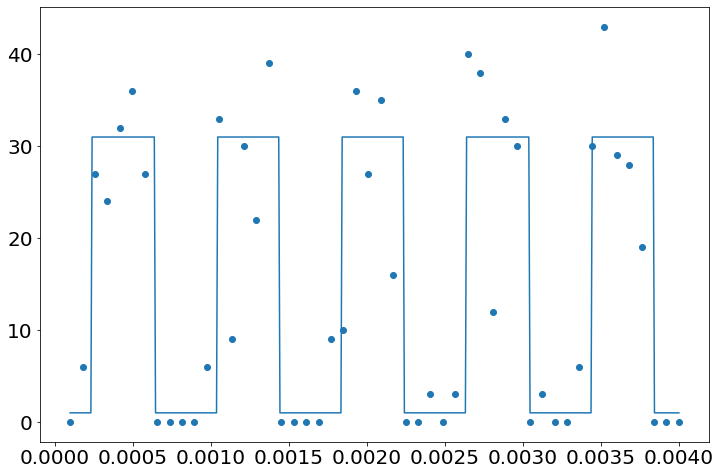

In [210]:
time = np.linspace(pixel_dwell_time, 40*pixel_dwell_time, 50)
time = time*10**-6
plot.scatter(time, odmr_data[1,0:50])
phase = find_phase_constant(odmr_data[1,0:50], pixel_dwell_time, mod_freq)
time_2 = np.linspace(pixel_dwell_time, 40*pixel_dwell_time, 500)
time_2 = time_2*10**-6
y = square_wave(time_2, 15, mod_freq+250, 16, 0.5, -phase)
plot.plot(time_2, y)
print(phase)
print(4*np.pi/10)
print(np.mean(odmr_data[1,0:50]))

In [46]:
print(demo)

(15000, 100)


In [21]:
print(freq)

[2.75    2.75002 2.75004 ... 2.99996 2.99998 3.     ]


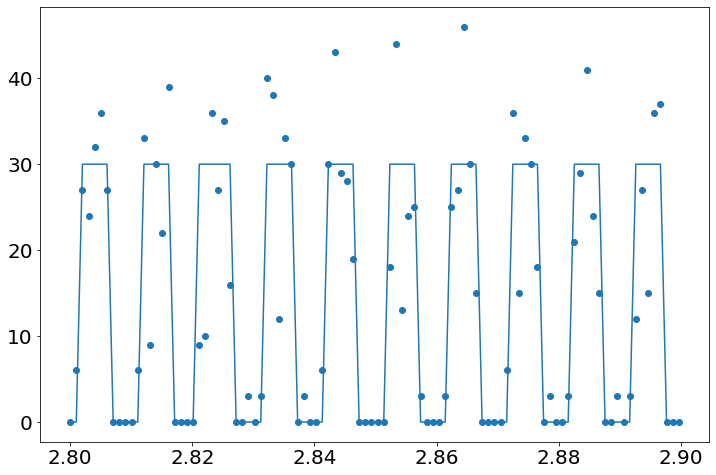

In [79]:
data_set = odmr_data[1,0:100]
y_fit = zeros_and_ones(data_set)
y_fit = np.array(y_fit)
plot.scatter(freq[0:100], data_set)
plot.plot(freq[0:100], y_fit*30)

In [15]:
print(x*y)

[ 0.  2.  8. 18. 32. 50.]
